#Eclerx

### Tweet data column summary:
tweet_id: The unique ID for this tweet

author_id: The unqiue ID for this tweet author (anonymized for non-company users)

inbound: Whether or not the tweet was sent (inbound) to a company

create_at: When the tweet was created

text: The text content of the tweet

response_tweet_id: The tweet that responded to this one, if any (parent id of this tweet's text)

in_response_to_tweet_id: The tweet this tweet was in response to, if any(child id of this tweet's text)

In [ ]:
# Dataset Download Link: https://drive.google.com/drive/folders/1p9kbpa8Y6yNPYezfE4CLjZGU5fUCF1ob?usp=sharing
'''Important to execute. '''
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount("/content/drive/", force_remount=True)
DATA_LOC = "/content/drive/My Drive/Eclerx/eclerx"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# !ls "/content/drive/My Drive/Eclerx/eclerx"
# !unzip "/content/drive/My Drive/Eclerx/eclerx/4133_8841_bundle_archive.zip" -d "/content/drive/My Drive/Eclerx/eclerx"
# !ls "/content/drive/My Drive/Eclerx/eclerx"

4133_8841_bundle_archive.zip
Archive:  /content/drive/My Drive/Eclerx/eclerx/4133_8841_bundle_archive.zip
  inflating: /content/drive/My Drive/Eclerx/eclerx/sample.csv  
  inflating: /content/drive/My Drive/Eclerx/eclerx/twcs/twcs.csv  
4133_8841_bundle_archive.zip  sample.csv  twcs


In [ ]:
!ls "/content/drive/My Drive/Eclerx/eclerx/twcs"

twcs.csv


In [ ]:
# MAX_VOCAB_SIZE = 2**13
# MAX_MESSAGE_LEN = 30  
# EMBEDDING_SIZE = 100
# CONTEXT_SIZE = 100
# BATCH_SIZE = 4
# DROPOUT = 0.2
# LEARNING_RATE=0.005

# UNK = 0 
# PAD = 1 
# START = 2
# SUB_BATCH_SIZE = 1000


In [ ]:
# Importing packages

import pandas as pd
import numpy as np
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

DATA_LOC = "/content/drive/My Drive/Eclerx/eclerx/twcs"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import os
# datafile = os.path.join(DATA_LOC, "twcs.csv")
# print(datafile)
# data = pd.read_csv(datafile)
# # data = data.head(1000)
# data.head()

In [ ]:
!ls "/content/drive/My Drive/Eclerx/eclerx/twcs/"

twcs.csv


In [ ]:
print("Total number of rows to compute: ", data.shape)

Total number of rows to compute:  (2811774, 7)


In [ ]:
inbound = data[data.inbound==True]

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sa = SentimentIntensityAnalyzer()

inbound['score'] = inbound.text.apply(lambda x: sa.polarity_scores(x)['compound'])
display(inbound.head())

,Unnamed: 0,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,score
0,1,2,115712.0,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,0.0000
1,2,3,115712.0,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,-0.2960
2,4,5,115712.0,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,0.0000
3,6,8,115712.0,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,-0.6249
4,8,12,115713.0,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,0.0000


In [ ]:
'''Saving inbound csv for checkpoint'''
inbound.to_csv(os.path.join(DATA_LOC, "pickle_inbound.csv"))

In [ ]:
'''Loading inbound csv'''
inbound = pd.read_csv(os.path.join(DATA_LOC, "pickle_inbound.csv"))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(inbound.shape)
inbound = inbound.head(100000) # <---------------------------- For sample
inbound.head()

(1756997, 9)


,Unnamed: 0,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,score
0,1,2,115712.0,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,0.0000
1,2,3,115712.0,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,-0.2960
2,4,5,115712.0,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,0.0000
3,6,8,115712.0,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,-0.6249
4,8,12,115713.0,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,0.0000


In [ ]:
print("Total reviews", inbound.shape)
inbound = inbound[inbound['score'] < 0.5]
print("Negative reviews", inbound.shape)

Total reviews (100000, 9)
Negative reviews (83526, 9)


In [ ]:
inbound.groupby('author_id')['text'].nunique().sort_values(ascending=False).rename('Count').to_frame()

,Count
author_id,
144768.0,53
115888.0,51
147113.0,48
123777.0,48
115911.0,43
...,...
137784.0,1
137785.0,1
155818.0,1


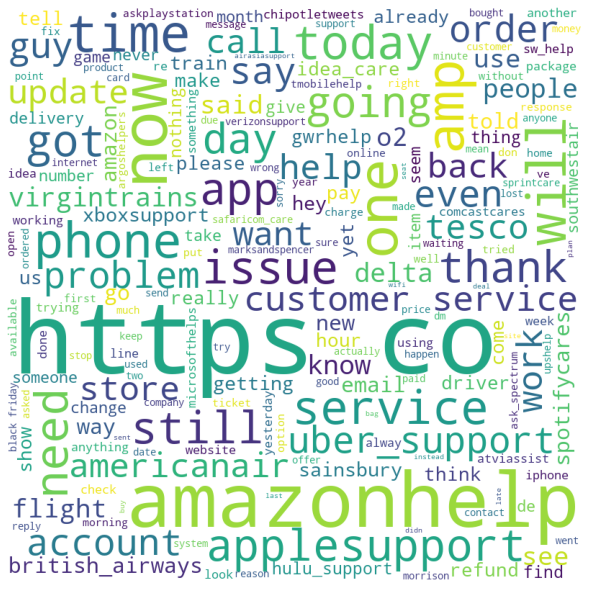

In [ ]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

tweets_total = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in inbound["text"]: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets_total += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(tweets_total) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Point to note:

Negative reviews are sharing links (word: https)

Product is not working

Product service is not good

time it is taking too much


In [ ]:

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # @param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)


def get_similarity_matrix(features, rotation):
  corr = np.inner(features, features)
  return corr

def embed_sim_matrix(messages_):
  message_embeddings_ = embed(messages_)
  print(message_embeddings_)
  return get_similarity_matrix(message_embeddings_, 90)
  

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
inbound_filter = inbound["text"].dropna()
print(len(inbound_filter))

83526


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # @param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)

features2 = embed(inbound_filter.values)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# from sklearn.preprocessing import StandardScaler
# features2 = StandardScaler().fit_transform(features2)

In [ ]:
def similarity(feature1, feature2):
  return np.sum(feature1*features2)

Text(0.5, 1.0, 'Semantic Textual Similarity')

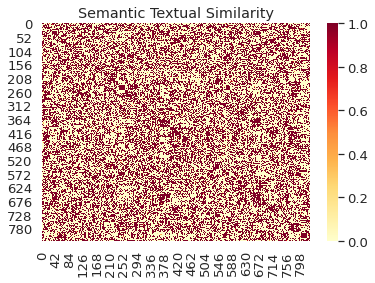

In [ ]:

sns.set(font_scale=1.2)
g = sns.heatmap(
    corr,
    # xticklabels=labels,
    # yticklabels=labels,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
# g.set_xticklabels(labels, rotation=rotation)
g.set_title("Semantic Textual Similarity")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words="english")
vec.fit(inbound_filter.values)
features = vec.transform(inbound_filter.values)

In [ ]:
features2.shape

(827, 512)

In [ ]:
similarity(features2[0], features2[1])

5.808686864838819e-13

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(metric=similarity, min_samples=10).fit(features2)
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

from sklearn import metrics
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


In [ ]:
# np.sum(clustering.labels_)
len(clustering.labels_)

827

In [ ]:
from tqdm import tqdm
first_inbound = data[pd.isnull(data.in_response_to_tweet_id) & data.inbound] 
inbounds_and_outbounds = pd.merge(first_inbound, data, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id').sample(frac=1)
# Filter to only outbound replies (from companies)
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]
tqdm().pandas()

0it [00:00, ?it/s]


In [ ]:
print("Inbound and outbound data:", inbounds_and_outbounds.shape)

Inbound and outbound data: (794299, 14)


In [ ]:
inbounds_and_outbounds.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
370166,1346855,434083,True,Fri Oct 27 15:58:05 +0000 2017,@115714 thanks for not honoring your deal @115...,1346853,NaN,1346853,sprintcare,False,Fri Oct 27 17:06:51 +0000 2017,@434083 We apologize for that. Can you send a ...,1346854,1346855.0
349036,1271284,417635,True,Thu Oct 26 12:34:01 +0000 2017,Thanks @Tesco for selling me an out-of-date sa...,"1271283,1271285,1271286,1271287",NaN,1271286,Tesco,False,Thu Oct 26 14:32:53 +0000 2017,@417635 I'd like to get this logged on our sys...,NaN,1271284.0
298651,1092832,377899,True,Mon Oct 23 19:57:12 +0000 2017,Well RIP my bag @SouthwestAir. Crushed my bag...,1092830,NaN,1092830,SouthwestAir,False,Mon Oct 23 20:40:35 +0000 2017,@377899 That's not what we like to hear! Be su...,1092831,1092832.0
833688,2852156,792989,True,Mon Nov 27 19:38:06 +0000 2017,@118919 delivery guy mentioned 10% cash back i...,2852154,NaN,2852154,AmazonHelp,False,Mon Nov 27 20:05:25 +0000 2017,@792989 We'd certainly help you with regard to...,2852155,2852156.0
551676,1948199,578847,True,Mon Oct 30 10:58:23 +0000 2017,Seriously @116136 you always pick the best tim...,1948198,NaN,1948198,comcastcares,False,Mon Oct 30 14:54:50 +0000 2017,@578847 Hi. I can definitely help with your se...,NaN,1948199.0


In [ ]:
import re
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return '@__sn__'

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Replacing anonymized screen names in X...")
x_text = inbounds_and_outbounds.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Replacing anonymized screen names in Y...")
y_text = inbounds_and_outbounds.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

  0%|          | 0/794299 [00:00<?, ?it/s]

Replacing anonymized screen names in X...


  1%|          | 5392/794299 [00:00<00:14, 53917.74it/s]

Replacing anonymized screen names in Y...


100%|██████████| 794299/794299 [00:06<00:00, 117343.42it/s]


In [ ]:
from nltk import casual_tokenize
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(tokenizer=casual_tokenize, max_features=MAX_VOCAB_SIZE - 3)
print("Fitting CountVectorizer on X and Y text data...")
count_vec.fit(tqdm(x_text + y_text))
analyzer = count_vec.build_analyzer()
vocab = {k: v + 3 for k, v in count_vec.vocabulary_.items()}
vocab['__unk__'] = UNK
vocab['__pad__'] = PAD
vocab['__start__'] = START
# Used to turn seq2seq predictions into human readable strings
reverse_vocab = {v: k for k, v in vocab.items()}
print(f"Learned vocab of {len(vocab)} items.")

Fitting CountVectorizer on X and Y text data...


  0%|          | 0/794299 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
100%|██████████| 794299/794299 [02:13<00:00, 5961.08it/s]


Learned vocab of 8192 items.


In [ ]:
# what might be the reasons?
# Check for the negative review first.
#   check for the word which is been utilized for the negative reviews after proper tokenization
#     for this just categroized based on the company.

# Check for the conversation if the replies are not good.
# Check sarcastic reviews


In [ ]:
# Check for Negative reviews

